# Fraud Detection Model Explainability with SHAP and LIME
In this notebook, I explore model explainability techniques using SHAP (Shapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to interpret a fraud detection model. Explainability is essential for understanding, trusting, and improving machine learning models, especially in fields like fraud detection, where knowing the `“why”` behind a model's decisions can help identify patterns and unusual behaviors in transactions.

This notebook will cover the following tasks:

* Using SHAP for Explainability:

**Summary Plot**: Provides a global view of feature importance, helping identify which factors most influence fraud predictions across the dataset.

**Force Plot**: Visualizes the contribution of each feature to a specific prediction, making it easier to understand individual instances.

**Dependence Plot**: Shows the relationship between individual features and the model output, highlighting feature interactions.

* Using LIME for Explainability:

**Feature Importance Plot**: Demonstrates the most influential features for a single prediction, giving insights into why a specific transaction was flagged as potentially fraudulent.

In [1]:
from IPython.display import clear_output
!pip install shap
!pip install lime
clear_output()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/MyDrive/Colab Notebooks/fraud_detection_project/notebooks'

/content/drive/MyDrive/Colab Notebooks/fraud_detection_project/notebooks


In [5]:
# Import neccessary modules
import pandas as pd
from sklearn.model_selection import train_test_split

import os, sys
# Add the 'src' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from explainability import FraudDetectionExplainer

# Configure logging
from logger import SetupLogger
# Assuming this class is defined in src/
from data_preprocessing import LoadData

logger = SetupLogger(log_file='../logs/model_XAI.log').get_logger()

In [6]:
# Initialize the LoadData class
fraud_data_init = LoadData(filepath='../data/processed/processed_fraud_data.csv', logger=logger)
fraud_data = fraud_data_init.load_dataset().set_index('user_id')

INFO:logger:Dataset loaded successfully.


In [7]:
# Convert signup_time and purchase_time to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Feature engineering: Calculate the time difference between signup and purchase
fraud_data['time_diff'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()

# Drop unnecessary columns
fraud_data = fraud_data.drop(columns=['Unnamed: 0', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])


# Define target and features
X_fraud = fraud_data.drop(columns=['class'])
y_fraud = fraud_data['class']

# Split for Fraud_Data.csv
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42)


In [9]:
# check the types of the columns of X_fraud_test
X_fraud_test.dtypes

,0
purchase_value,float64
age,float64
hour_of_day,float64
day_of_week,float64
purchase_delay,float64
user_transaction_frequency,float64
device_transaction_frequency,float64
user_transaction_velocity,float64
source_Direct,bool
source_SEO,bool


In [17]:
# Convert boolean columns to float64
X_fraud_test = X_fraud_test.astype(float)



 99%|===================| 29897/30223 [00:24<00:00]       

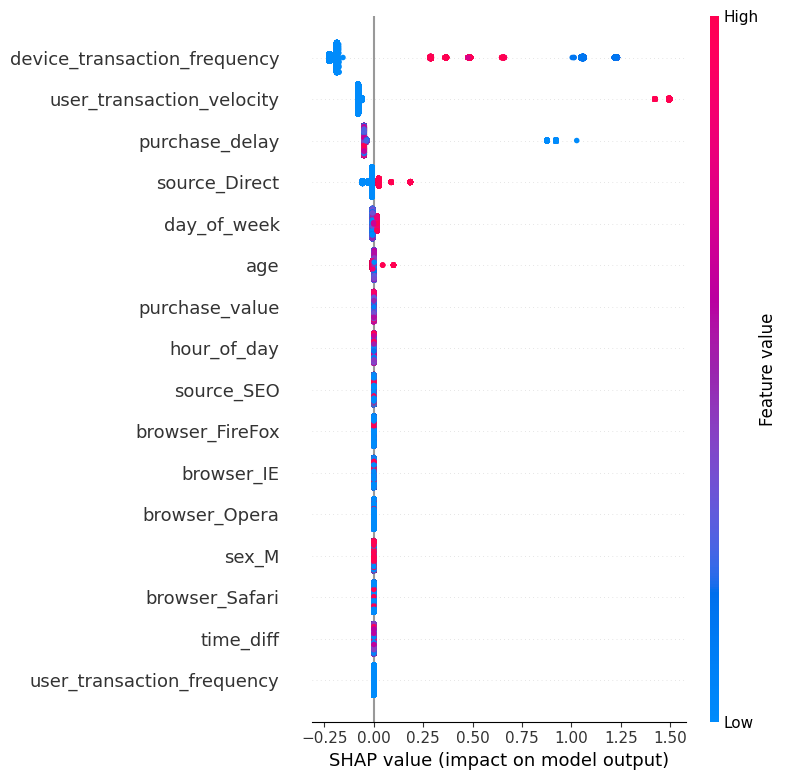

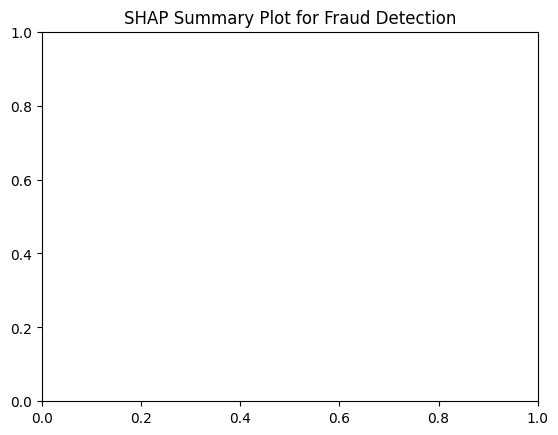

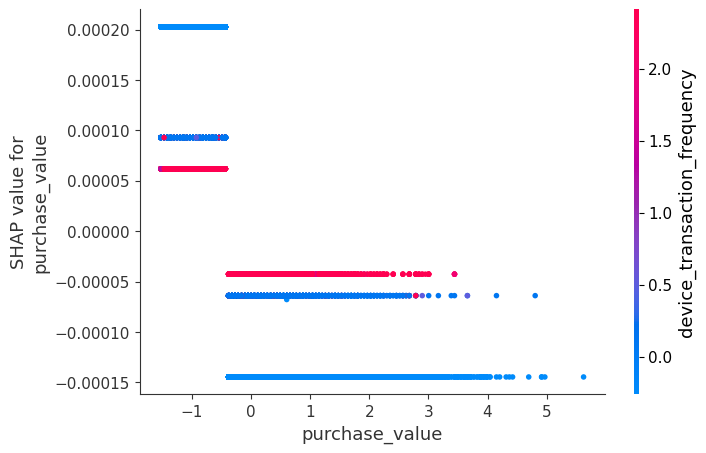

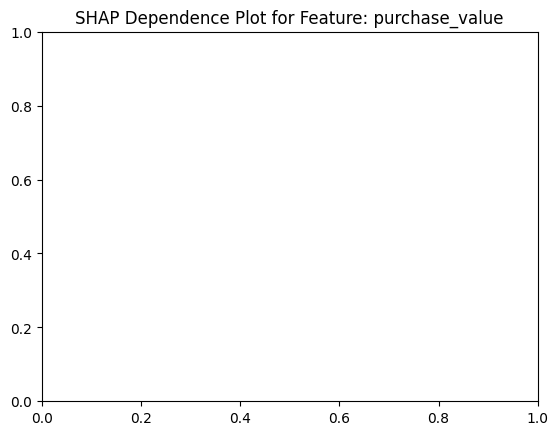

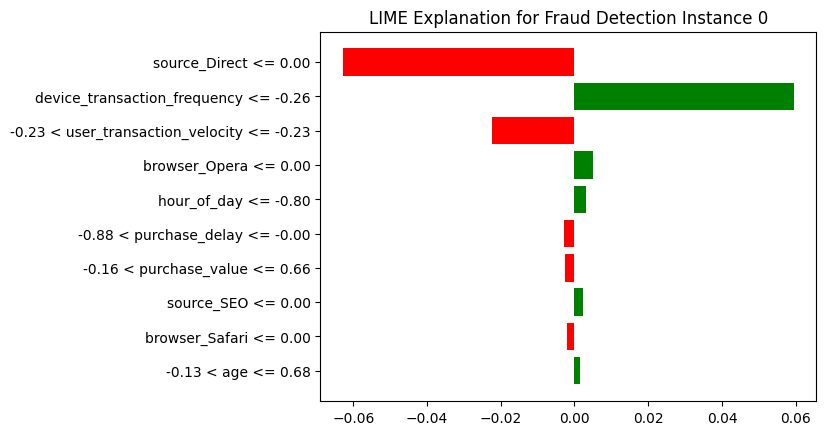

In [24]:
explainer = FraudDetectionExplainer("../best_models/gradient_boosting_fraud_data_best_model.pkl", X_fraud_test)

explainer.explain()

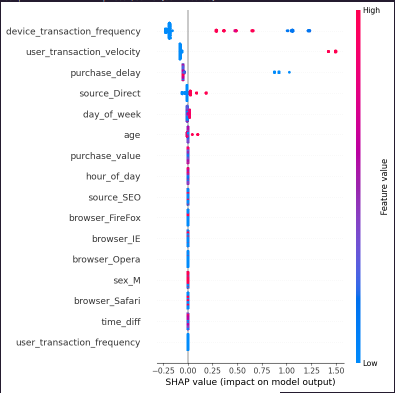

This SHAP summary plot shows the impact of each feature on the model's output for fraud detection.

- **Key Indicators**: device_transaction_frequency, user_transaction_velocity, and purchase_delay are the top features influencing fraud predictions.
- **High-Value Trends**: Higher values of device_transaction_frequency and user_transaction_velocity generally increase fraud likelihood.
- **Categorical Features**: Certain categorical variables (like source_Direct and specific browser types) also impact predictions, with specific categories associated with higher fraud risk.

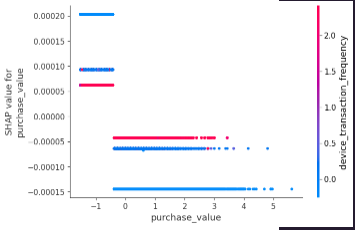

A SHAP (SHapley Additive exPlanations) plot, showing the impact of the `purchase_value` feature on the model's predictions. The SHAP value for purchase_value is on the y-axis, and the purchase_value itself is on the x-axis. The color gradient represents another feature, device_transaction_frequency, which varies from `blue (lower frequency)` to `red (higher frequency)`.

Overall, while purchase_value doesn’t strongly influence the model for most data points, its impact appears slightly more pronounced when device_transaction_frequency is high. This plot could be used to further analyze how these features interact to affect the prediction.


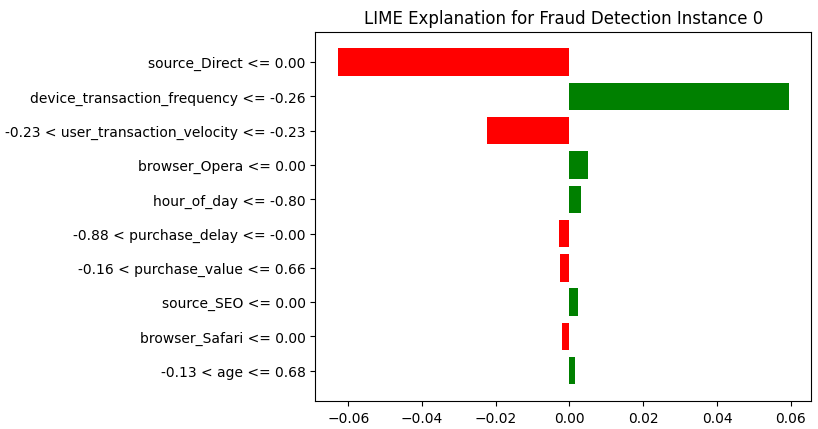

This LIME plot explains the prediction for a specific fraud detection instance. Key points:

- **Most Impactful Features**: source_Direct reduces the fraud likelihood, while device_transaction_frequency increases it.
- **Other Features**: user_transaction_velocity, browser_Opera, and hour_of_day have smaller, mixed impacts.
- **Color Coding**: Red bars indicate non-fraud contributions, and green bars indicate fraud contributions.

In short, source_Direct and device_transaction_frequency are the strongest influencers in this fraud prediction.